In [10]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.pylabtools import figsize
% matplotlib inline
from scipy import stats
import pymc as pm

Text(0.5, 1.0, 'ガンマ分布')

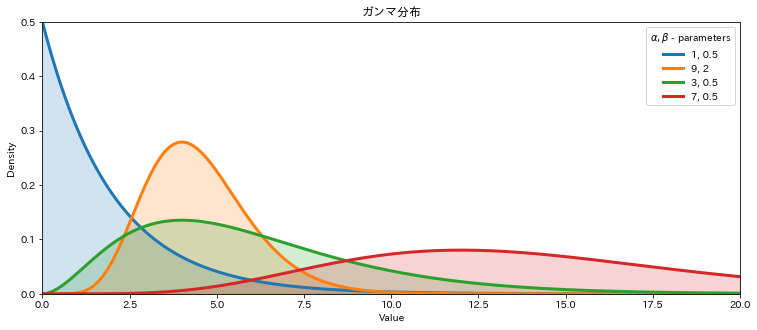

In [9]:
figsize(12.5 , 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1. / beta)
    lines = plt.plot(x, y, label="{}, {}".format(alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("ガンマ分布")

Text(0.5, 0.98, 'ウィシャーと分布からランダムにサンプリングした4x4と15x15の行列')

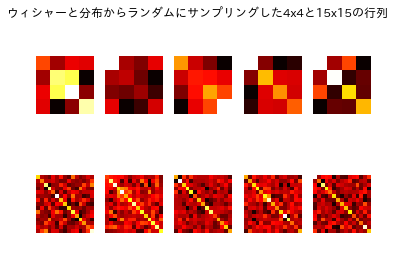

In [13]:
n = 4
hyperparameter = np.eye(n)
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(pm.rwishart(n + 1, hyperparameter), interpolation="none", cmap=plt.cm.hot)
    ax.axis("off")
    
n = 15
hyperparameter = 10 * np.eye(n)
for i in range(5, 10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(pm.rwishart(n + 1, hyperparameter), interpolation="none", cmap=plt.cm.hot)
    ax.axis("off")
    
plt.suptitle("ウィシャーと分布からランダムにサンプリングした4x4と15x15の行列")

Text(0.5, 1.0, 'ベータ分布')

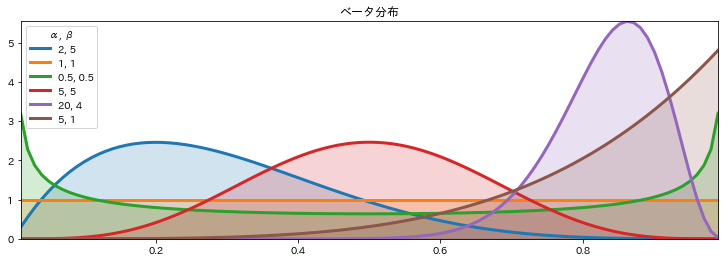

In [16]:
figsize(12.5, 4)
params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]
x = np.linspace(0.01, .99, 100)

beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="{}, {}".format(a, b), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title="α, β")
plt.title("ベータ分布")

In [18]:
from pymc import rbeta

class Bandits(object):
    """
    N個のバンディットを表すクラス
    パラメータ: p-array: 0から1までのN個の確率のNumpy array
    メソッド: pull(i): アームを引いた結果（0か1）を返す 
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        # i番目のアームを引く. 勝ったらTrue. 負けたらFalseを返す.
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)
    
class BayesianStrategy(object):
    """
    多椀バンディット問題を解くオンライン学習の実装
    パラメータ: bandits: バンディットクラス
    メソッド: sample_bandits(n): n回引いて学習する
    属性:
        N: サンプルの累積個数
        choices: N回の選択履歴のarray
        bb_score: N回のスコア履歴のarray
    """
    def __init__(self, bandits):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_bandits(self, n=1):
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            # バンディットの事前分布からサンプリングし,
            # 最も大きいサンプルを選択する.
            choice = np.argmax(
            rbeta(1 + self.wins, 1 + self.trials - self.wins))
            
            # 選択したバンディットからサンプリング
            result = self.bandits.pull(choice)
            
            # 事前分布とスコアを更新
            self.wins[choice] += result # 1 or 0 
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice
        
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
            

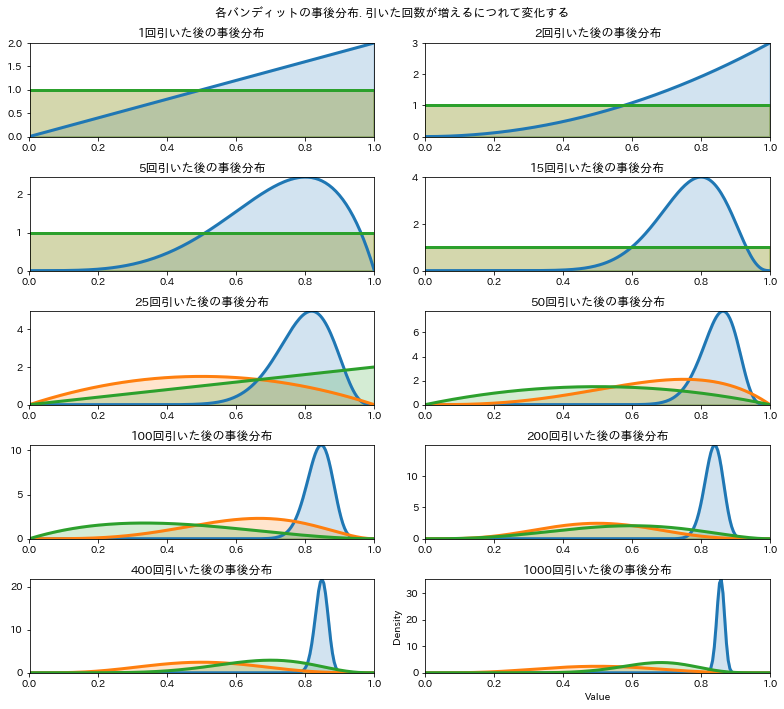

In [23]:
figsize(11.0, 10)
beta = stats.beta
x = np.linspace(0.001, .999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # prob: 各バンディットの当たり確率のarray
    # プロット関数
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor() # マーカーエッジカラーを取得
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha, lw=2)
        plt.autoscale(tight=True)
        plt.title("{}回引いた後の事後分布".format(bayesian_strategy.N))
    return

hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    plt.autoscale(tight=True)

plt.xlabel("Value")
plt.ylabel("Density")
plt.tight_layout()

plt.suptitle("各バンディットの事後分布. 引いた回数が増えるにつれて変化する")
plt.subplots_adjust(top=.93)

In [25]:
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXL9A", "other_strats.py")

('other_strats.py', <http.client.HTTPMessage at 0x1a28555c88>)

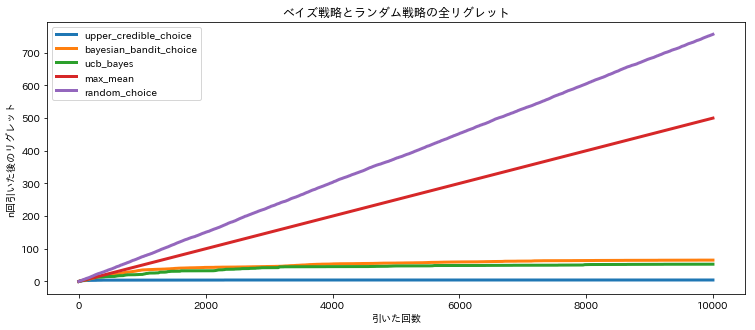

In [33]:
figsize(12.5, 5)
from other_strats import *

# もっと難しい問題を定義
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

# リグレットを定義

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# 新しい戦略を作成
strategies = [upper_credible_choice, # 最大ベイズ信用区間上限
              bayesian_bandit_choice,     # ベイズバンディット戦略
              ucb_bayes,                        # ベイズ - UCBアルゴリズム
              max_mean,                        # 最大観測割合
              random_choice                  # ランダム　
             ]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

# 10000回のサンプルで学習
for strat in algos:
    strat.sample_bandits(10000)
    
# テストしてプロット
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)
    
plt.title("ベイズ戦略とランダム戦略の全リグレット")
plt.xlabel("引いた回数")
plt.ylabel("n回引いた後のリグレット")
plt.legend()

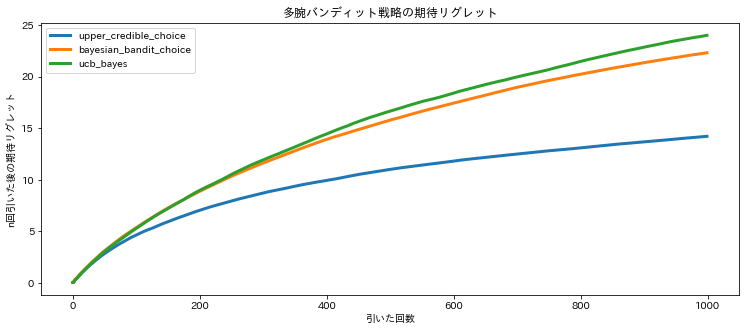

In [34]:
trials = 200
expected_total_regret = np.zeros((1000, 3))

for i_strat, strat in enumerate(strategies[: -2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(1000)
        _regret = regret(hidden_prob, general_strat.choices)
        expected_total_regret[:, i_strat] += _regret
    plt.plot(expected_total_regret[:, i_strat] / trials, lw=3, label=strat.__name__)

plt.title("多腕バンディット戦略の期待リグレット")
plt.xlabel("引いた回数")
plt.ylabel("n回引いた後の期待リグレット")
plt.legend()

Text(0.5, 1.0, '対数スケール')

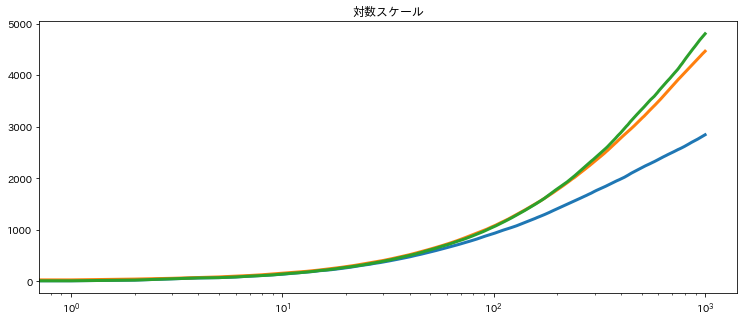

In [35]:
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0, 1, 2]],lw=3)
plt.xscale("log")
plt.title("対数スケール")

[0.2458342  0.147236   0.07460281 0.12641127 0.07772831 0.05105124
 0.01823527 0.08860126 0.03403935 0.02264948 0.09517011 0.01834793
 0.04131825 0.00088108 0.08575123 0.03988675 0.05032358 0.04595912
 0.06551403 0.13760391 0.03131152 0.10249969 0.20329591 0.01055713
 0.03307307 0.08860355 0.08893694 0.05519047 0.07506445 0.00094181
 0.0026467  0.15779102 0.05434333 0.0451039  0.20825339]


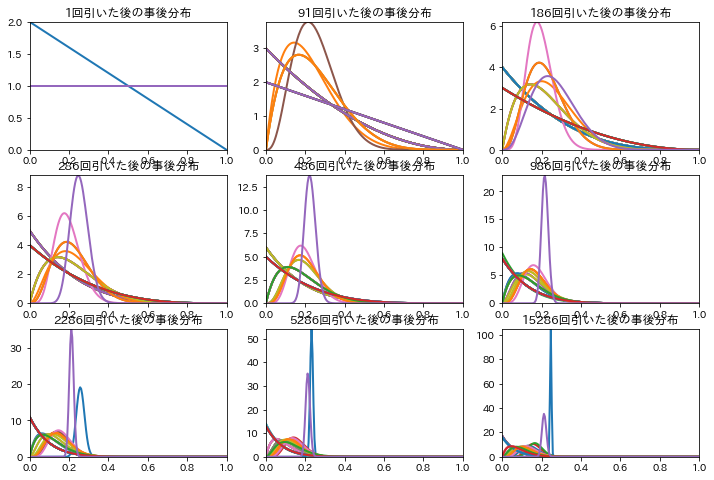

In [43]:
figsize(12.0, 8)

beta = stats.beta
hidden_prob = beta.rvs(1, 13, size=35)
print(hidden_prob)

bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j, i in enumerate([1,90,95,100, 200, 500, 1300,3000,10000]):
    plt.subplot(3, 3, j +1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw=2, alpha=0.0)
    plt.xlim(0, 1.0)

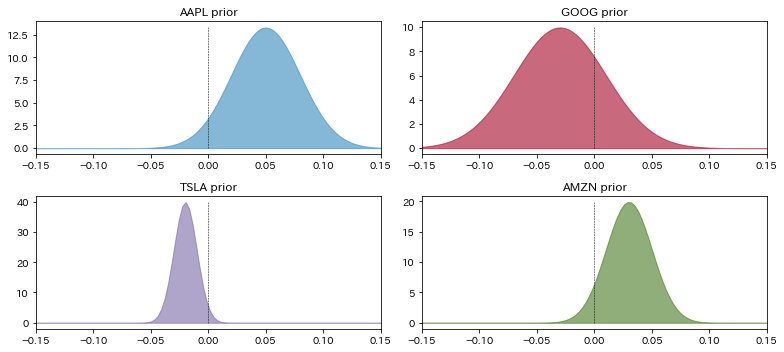

In [47]:
figsize(11.0, 5)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

noraml = stats.norm
x = np.linspace(-0.15, 0.15, 100)

expert_prior_params = {
    "AAPL": (0.05, 0.03),
    "GOOG": (-0.03, 0.04),
    "TSLA": (-0.02, 0.01),
    "AMZN":(0.03, 0.02)
                      }

for i, (name, params) in enumerate(expert_prior_params.items()):
    plt.subplot(2, 2, i +1)
    y = noraml.pdf(x, params[0], scale=params[1])
    plt.fill_between(x, 0, y, color=colors[i], alpha=0.6)
    plt.title(name + " prior")
    plt.vlines(0, 0, y.max(), "k", "--", linewidth=0.5)
    plt.xlim(-0.15, 0.15)
    plt.tight_layout()

In [48]:
import pymc as pm
n_observations = 100 # 過去100日で打ち切る

prior_mu = np.array([x[0] for x in expert_prior_params.values()])
prior_std = np.array([x[1] for x in expert_prior_params.values()])

inv_cov_matrix = pm.Wishart("inv_cov_matrix", n_observations, np.diag(prior_std **2))
mu = pm.Normal("returns", prior_mu, 1, size=4)

In [49]:
urlretrieve("https://git.io/vXLHQ", "ystockquote.py")

('ystockquote.py', <http.client.HTTPMessage at 0x1a2b1d3ba8>)

In [52]:
list(map(lambda x: x[0]+x[1], zip([1,2,3],[4,5,6])))

[5, 7, 9]

In [55]:
import datetime
import ystockquote as ysq

In [60]:
import datetime
import collections
import ystockquote as ysq
import pandas as pd

n_observations = 100 # we will truncate the the most recent 100 days.

stocks = ["AAPL", "GOOG", "TSLA", "AMZN"]

enddate = "2015-04-27"
startdate = "2012-09-01"

CLOSE = 6

stock_closes = pd.DataFrame()

for stock in stocks:
    x = np.array(ysq.get_historical_prices(stock, startdate, enddate))
    stock_series = pd.Series(x[1:,CLOSE].astype(float), name=stock)
    stock_closes[stock] = stock_series

stock_closes = stock_closes[::-1]
stock_returns = stock_closes.pct_change()[1:][-n_observations:]
    
dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations+1,0]))

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [56]:
# リターンを作成
for stock in stocks:
    _previous_day = np.roll(stock_closes[stock], -1)
    stock_returns[stock] = ((stock_closes[stock] - _previous_day) / _previous_day)[:n_observations]
    dates = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), x[1:n_observations + 1, 0]))
    

igsize(12.5, 4)

for _stock, _returns in stock_returns.items():
    p = plt.plot((1 + _returns)[::-1].cumprod() - 1, '-o', label="%s" % _stock,
                 markersize=4, markeredgecolor="none")

plt.xticks(np.arange(100)[::-8],
           list(map(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"), dates[::8])),
           rotation=60);

plt.legend(loc="upper left")
plt.title("Return space")
plt.ylabel("Return of $1 on first date, x100%");

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>